In [1]:
import os
import re 
import numpy as np
import xarray as xr
import rioxarray
from datetime import date
from datetime import datetime
from datetime import timedelta
import julian

In [2]:
infolder = 'CFSv2/onsetforecast/'
outfolder = "CFSv2/geotiff/"

files = [f for f in os.listdir(infolder) if re.match('mes_20ensemble_(\d+)\.nc$', f)]


In [3]:
for filename in files:
    dataset = xr.open_dataset(infolder + filename)

    for i in range(len(dataset.outoday.lat)):
        for j in range(len(dataset.outoday.lon)):
            dataset.outoday[: ,i,j] = dataset.outoday[: ,i,j].where(dataset.outoday[: ,i,j] != dataset.outoday[: ,i,j].min())
            dataset.outoday[: ,i,j] = dataset.outoday[: ,i,j].where(dataset.outoday[: ,i,j] != dataset.outoday[: ,i,j].max())
    
    mean = dataset.mean(dim = 'time', skipna = True, keep_attrs = True)
    outoday_mean = mean.outoday.rio.set_spatial_dims('lon', 'lat')
    outoday_mean.rio.to_raster(outfolder+filename+'.tif')

/home/fernando/.local/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/fernando/.local/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/fernando/.local/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/fernando/.local/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/fernando/.local/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/fernando/.local/lib/python3.7/site-packages/xarray/core/nputils.py:215: Ru

In [4]:
mask_lon = (outoday_mean.lon >= -49.2188960804658393) & (outoday_mean.lon <= -40.7814055050120032)
mask_lat = (outoday_mean.lat >= -17.0078089375000019) & (outoday_mean.lat <= -8.5039080625000008)

In [5]:
croped_outoday_mean = outoday_mean.where(mask_lon & mask_lat, drop=True)

In [6]:
new_lon = np.linspace(croped_outoday_mean.lon[0], croped_outoday_mean.lon[-1], 1000)
new_lat = np.linspace(croped_outoday_mean.lat[0], croped_outoday_mean.lat[-1], 1000)

In [7]:
interpolation = croped_outoday_mean.interp({'lat':new_lat, 'lon':new_lon})

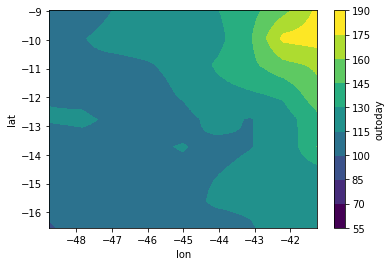

In [9]:
interpolation.plot(levels=[55, 70, 85, 100, 115, 130, 145, 160, 175, 190])

In [10]:
# Origem jd: 
#    meio-dia de 01 de janeiro de 4713 a.C. pelo calendário juliano
#    meio-dia de 24 de novembro de 4714 a.C., pelo calendário gregoriano.

In [11]:
# idt = datetime(2019, 7, 1)

In [12]:
# def deltaDaysFromPixelDate(idt, pdt):
#     """
#     Args:
#         idt: initial date time (datetime.datetime object)
#         pdt: data from xarray 2D dataset
#     """
    
#     jd_idt = julian.to_jd(idt, fmt='jd')
    
#     for i in range(pdt.shape[1]):
#         for j in range(pdt.shape[2]):
#             pdt[0, i, j] = julian.to_jd(idt + timedelta(days = pdt[0, i, j]), fmt='jd')
            
#     return pdt

In [13]:
# jd_da.data = deltaDaysFromPixelDate(idt, jd_da.data)

In [16]:
import gdal

In [18]:
gdal.Polygonize( interpolation, None, 'pol.shp', -1, [], callback=None )

TypeError: in method 'Polygonize', argument 1 of type 'GDALRasterBandShadow *'

<xarray.DataArray 'outoday' (lat: 1000, lon: 1000)>
array([[ 98.8888855 ,  98.93292954,  98.97697359, ..., 120.90846074,
        120.89867312, 120.8888855 ],
       [ 98.92403182,  98.96794404,  99.01185627, ..., 120.92057877,
        120.91118305, 120.90178733],
       [ 98.95917813,  99.00295854,  99.04673894, ..., 120.93269681,
        120.92369298, 120.91468915],
       ...,
       [107.98498157, 107.99644186, 108.00790215, ..., 177.98730973,
        178.1632378 , 178.33916587],
       [107.93693353, 107.94844726, 107.95996099, ..., 177.95413979,
        178.13130411, 178.30846843],
       [107.8888855 , 107.90045267, 107.91201984, ..., 177.92096986,
        178.09937043, 178.277771  ]])
Coordinates:
  * lat      (lat) float64 -16.54 -16.53 -16.52 -16.51 ... -8.991 -8.984 -8.976
  * lon      (lon) float64 -48.75 -48.74 -48.74 -48.73 ... -41.27 -41.26 -41.25

In [18]:
interpolation = interpolation.rio.set_spatial_dims('lon', 'lat')
interpolation.rio.to_raster('interpolation.tif')